# Fitting COVID19 trends using Bayesian method

In this assignment, our goal is to fit the COVID 19 trends (confirmed cases of COVID 19 as a function of date) using the generalized growth model given by

\begin{align}
\frac{d C(t)}{dt} = r C(t)^p, \label{eq:ode} \tag{1}
\end{align}

where $t \in [0,T]$ is the time (in units of days), $r \geq 0$ is the growth rate, $p
\in [0,1]$ is the 'decceleration of growth' parameter, see **Viboud et al 2015**. Special cases: $p = 0$ gives linear growth model and $p=1$ gives exponential growth model. 

$C : [0,T] \to [0, \infty)$ is the total confirmed COVID 19 cases at time $t$. When $0 < p < 1$, Eq (1) can be solved to get 

\begin{align}
C(t) = \left( \frac{r}{m}t + (C_0)^{1/m} \right)^m, \label{eq:model} \tag{2}
\end{align}

where $m = 1/(1 - p)$ and $C_0 = C(0)$ is the initial condition. For special cases $p=0$ and $p=1$, $C$ can be found easily.

- When $p=0$, $C = C_0 + rt$

- When $p=1$, $C = C_0 \exp[rt]$

## Alternative model
Another model is given as

\begin{align}
C(t) = a \exp\left[b\left(1 - \frac{1}{1-(1-t/T)^p}\right)\right] + C_0, \label{eq:model3} \tag{3}
\end{align}

where $a,b$ are model parameters and $p>1$ is the fixed exponent. 

# 1. Problem

We cosider COVID 19 data at discrete times $\bar{t} = (t_1=0, t_2=1, ..., t_N=83)$, where $N = 84$, and corresponding total confirmed cases $Y(\bar{t}) = (Y_1, Y_2, ..., Y_N)$.

Model prediction is $C(\bar{t}) = (C(t_1), C(t_2), ..., C(t_N))$ where $C(t_i)$ is given by Eq (2). The model parameters are $\theta = (r, p)$. Take uniform prior for $\theta$ and consider a Guassian noise with zero mean and standard deviation $\sigma$. Divide the data in calibration and validation by taking first $N_c = 50$ as the calibration data and rest $N_v = N - N_c$ as validation data. You can also try different priors for parameters and divide data differently in calibration and validation set.

Problem: Predict the total confirmed cases at $T = 100$ day for three countries US, Japan, and South Korea.

## 1.1 Data
Data for current epidemic COVID 19 can be found in several places such as:

- [datasets/covid-19](https://github.com/datasets/covid-19)

- [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

- [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)


In [StudyCovid19](https://github.com/prashjha/StudyCovid19) you will find python scripts to process data and this notebook in directory `process/bayesian`.


Below we plot the confirmed cases for various countries

In [1]:
import pandas as pd
import sys
sys.path.insert(0,'../')

In [2]:
# from data import plot_countries_all_plus_normalize_1 as plot
# from data import save_country_data_1 as save
# df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')
# # plot
# plot(df, ['US', 'Japan', 'Korea, South'])
# # save data
# save(df, ['US', 'Japan', 'Korea, South'])

# 2. Inplement Bayessian Method 
Take South Korea as an example. Following we will apply the calibration and validation, and give QoI(#Confirmed case)'s expectation and distribution.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from models import model1, model3
T = 100

## 2.1 Preparation
Given data of a specific country, we fist need to split it into a training set and a testing set. My approach is to set 80% of the data as training, and the rest 20% as testing. Also, we need to specify a forward model which takes some parameters as input and returns the numbers of confirmed cases as its output. The models are aready given above. 

To apply the bayessian rule we need a prior and a likelihood function. Here we give prior as an uniform distribution, which implies that we know nothing about the parameters initially. And here we give likelihood as an Gaussian distribution, which is because we suppose a Gaussian noise of the data.

In [4]:
# prepare data, model, and the corresponding prior and likelihood
def prepare_data(country):
    # open file
    df = pd.read_csv(country+'.csv',header=None)
    data = np.array(df)
    # split into calibration and validation sets
    train_size = int(data.shape[0] * 0.8)
    data_c = data[:train_size,:]
    data_v = data[train_size:,:]
    return data_c, data_v

def prepare_model(model,country,data):
    # # model 1
    # model = model1
    # fixed_param = [data[0,1]]
    # trans_param[0.01,0.0001]
    # param_init = [0.5,0.5]  
    # def prior(theta):
    #     if theta[0]<0 or theta[1]<0 or theta[1]>1:   # r>0  0<=p<=1
    #         return 1e-8
    #     return 1

    # prepare model 3
    if model == model3:
        # uniform prior
        def log_prior_c(theta):
            if theta[0]<0 or theta[1]<0:   # a>0,b>0
                return -np.inf
            return 0
        # arguments used in the model
        fix_params = [data[0,1],T,4]
        if country=='Korea, South':
            noise_arg = 10.
            trans_param = [noise_arg,.001*noise_arg]
            param_init = [12000,8]
        if country=='US':
            noise_arg = 100.
            trans_param = [100,.1]
            param_init = [480000,100]
        #                          [[data[0,1],100.,4], [1,.001], [646300,132.5]] ]
        if country=='Japan':
            noise_arg = 10.
            trans_param = [1,.001]
            param_init = [1000,8]
        #                             [[data[0,1],100.,4], [10,.01], [7300,135]] 
    return noise_arg, log_prior_c, fix_params, trans_param, param_init

def log_likelihood(theta, data):
    tdata = data[:,0]
    ydata = data[:,1]
    return np.sum( - np.log(noise_arg * np.sqrt(2*np.pi)) 
                   - ((ydata-model(theta,tdata,fix_params))**2)/(2*noise_arg**2) )

In addition, we will use MCMC to draw samples from the posterior we derive. Here we inplement the Metropolis–Hastings algorithm. 

In [5]:
# prepare MCMC
def acceptance_rule(x, x_new):     # acceptance rule under log density
    if x_new>x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))
    
def metropolis_hastings(log_likelihood,log_prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    theta = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        theta_new = transition_model(theta)    
        lik = log_likelihood(theta,data)
        lik_new = log_likelihood(theta_new,data) 
        if (acceptance_rule(lik + log_prior(theta),lik_new + log_prior(theta_new))):            
            theta = theta_new
            accepted.append(theta_new)
        else:
            rejected.append(theta_new)            
    return np.array(accepted), np.array(rejected)

def show_mcmc(accepted, rejected):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(accepted[:,0], accepted[:,1], label="Path")
    ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
    ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
    ax.set_xlabel("first parameter")
    ax.set_ylabel("second parameter")
    ax.legend()
    ax.set_title("MCMC sampling with Metropolis-Hastings. All samples are shown.") 

def burn_accepted(accepted, burn_in=0.8, show=True):
    total_iters = accepted.shape[0]
    burnin_iters = int(burn_in*accepted.shape[0])
    accepted_burnin = accepted[:burnin_iters,:]
    accepted_burned = accepted[burnin_iters:,:]
    if show:
        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(1,2,1)
        ax.plot(range(burnin_iters),accepted_burnin[:,0], color='gray', label='burn_in')
        ax.plot(range(burnin_iters,total_iters),accepted_burned[:,0], color='blue', label='burned')
        ax.set_title("Trace for #1 parameter")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("#1 parameter")
        ax.legend()
        ax = fig.add_subplot(1,2,2)
        ax.hist(accepted_burned[:,0], bins=20, density=True)
        ax.set_ylabel("Frequency (normed)")
        ax.set_xlabel("#1 parameter")
        ax.set_title("Histogram of #1 parameter (burned)")
        fig.tight_layout()

        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(1,2,1)
        ax.plot(range(burnin_iters),accepted_burnin[:,1], color='gray', label='burn_in')
        ax.plot(range(burnin_iters,total_iters),accepted_burned[:,1], color='blue', label='burned')
        ax.set_title("Trace for #2 parameter")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("#2 parameter")
        ax = fig.add_subplot(1,2,2)
        ax.hist(accepted_burned[:,1], bins=20, density=True)
        ax.set_ylabel("Frequency (normed)")
        ax.set_xlabel("#2 parameter")
        ax.set_title("Histogram of #2 parameter (burned)")
        fig.tight_layout()    
    return accepted_burned

## 2.2 Let's start with a country and a method!

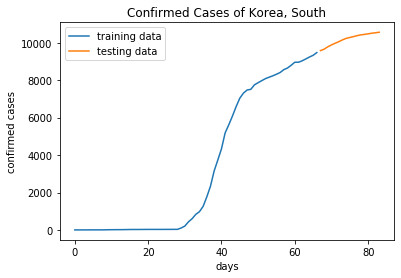

In [6]:
country = 'Korea, South'
model = model3
data_c, data_v = prepare_data(country)
noise_arg, log_prior_c, fix_params, trans_param_c, param_init_c = prepare_model(model,country,data_c)

plt.plot(data_c[:,0],data_c[:,1], label="training data")
plt.plot(data_v[:,0],data_v[:,1], label="testing data")
plt.xlabel("days")
plt.ylabel("confirmed cases")
plt.legend()
plt.title("Confirmed Cases of "+ country) 
plt.show()

## 2.3 Calibration

In [7]:
transition_model_c = lambda theta: np.random.normal(theta,trans_param_c,(2,))
accepted_c, rejected_c = metropolis_hastings(log_likelihood,log_prior_c,transition_model_c,
                                             param_init_c,50000,data_c,acceptance_rule)
print('# accepted = ' + str(accepted_c.shape[0]))

# accepted = 8641


[1.11896975e+04 6.85950117e+00]
[[1.78047420e+01 1.48195391e-02]
 [1.48195391e-02 2.70631870e-05]]


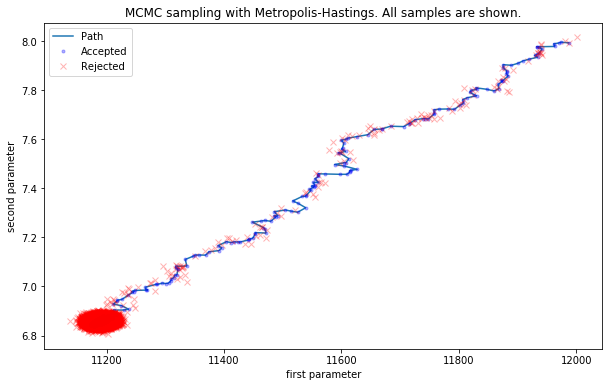

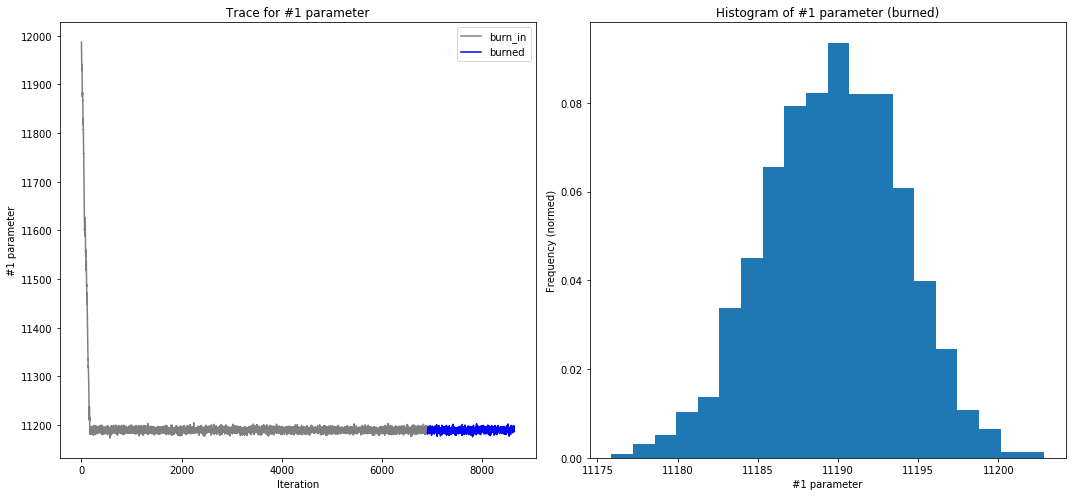

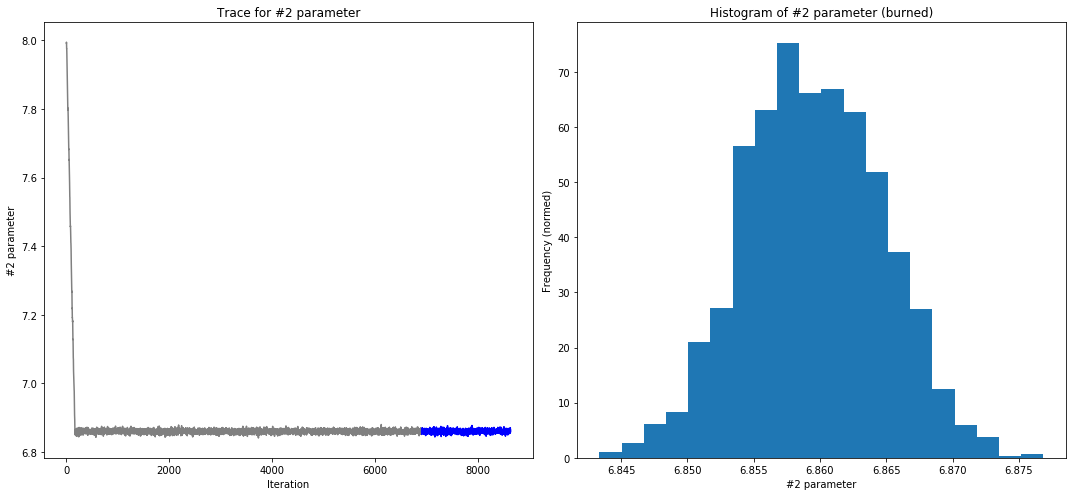

In [8]:
show_mcmc(accepted_c, rejected_c)
accepted_burned_c = burn_accepted(accepted_c, burn_in=0.8, show=True)

mean_c = np.mean(accepted_burned_c, axis=0)
cov_c = np.cov(accepted_burned_c.T)
print(mean_c)
print(cov_c)

In [9]:
# # plot the curve
# plt.plot(data_c[:,0],data_c[:,1], label="train set")
# plt.plot(data_v[:,0],data_v[:,1], label="test set")
# plt.plot(np.arange(T), model(cal_mean, np.arange(T), fix_params), label="model after calibration")

# plt.xlabel("days")
# plt.ylabel("confirmed cases")
# plt.legend()
# plt.title("Confirmed Cases of "+ country) 
# plt.show()

## 2.4 Validation

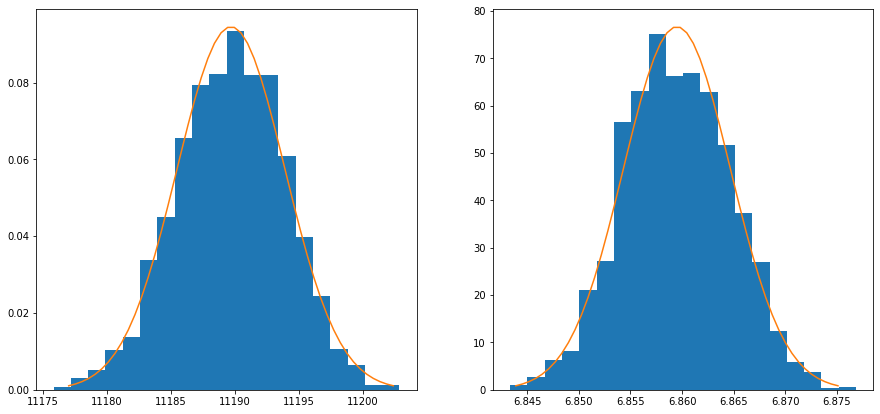

In [10]:
# # plot prior of validation 
fig = plt.figure(figsize=(15,7))
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.hist(accepted_burned_c[:,i], bins=20, density=True)
    x0 = np.linspace(mean_c[i]-3*np.sqrt(cov_c[i,i]),mean_c[i]+3*np.sqrt(cov_c[i,i]))
    ax.plot(x0,multivariate_normal.pdf(x0, mean=mean_c[i], cov=cov_c[i,i]), label="gaussian approx")
plt.show()

In [11]:
param_init_v = mean_c
def log_prior_v(theta):
    return multivariate_normal.logpdf(theta, mean=mean_c, cov=cov_c)
transition_model_v = lambda theta: multivariate_normal.rvs(mean=theta, cov=cov_c)
# transition_model_v = lambda theta: np.random.normal(theta,trans_param_c,(2,))
accepted_v, rejected_v = metropolis_hastings(log_likelihood,log_prior_v,transition_model_v,
                                             param_init_v,50000,data_v,acceptance_rule)
print('# accepted = ' + str(accepted_v.shape[0]))

# accepted = 20641


[1.07008045e+04 6.48136817e+00]
[[5.54042653e+00 5.14050217e-03]
 [5.14050217e-03 1.95599383e-05]]


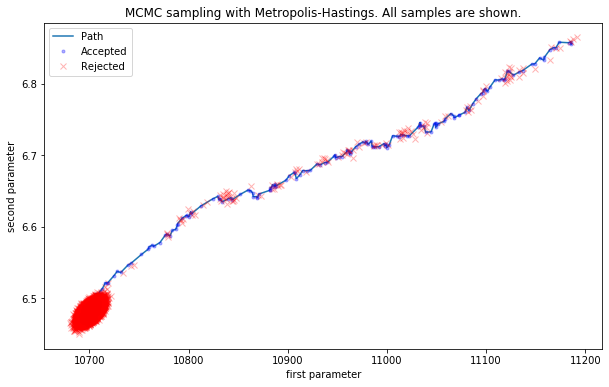

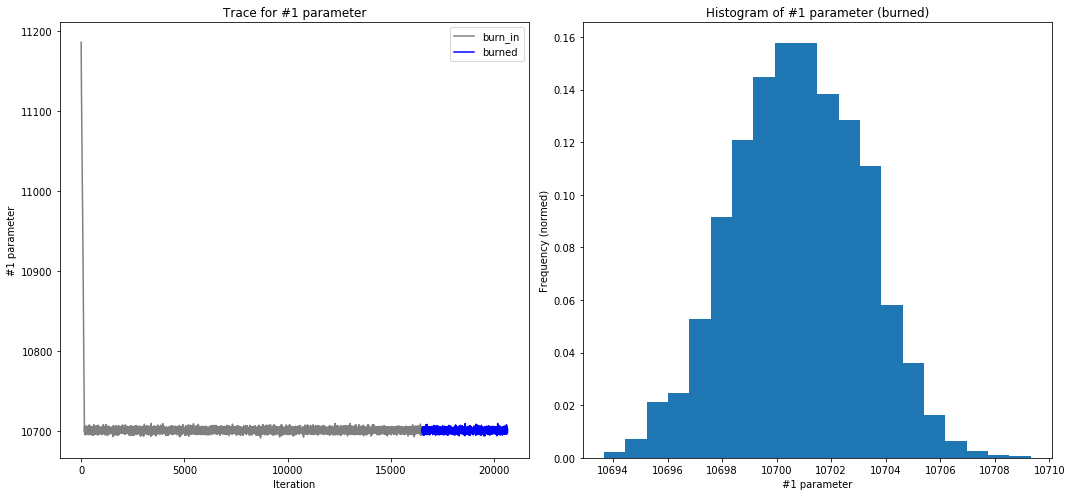

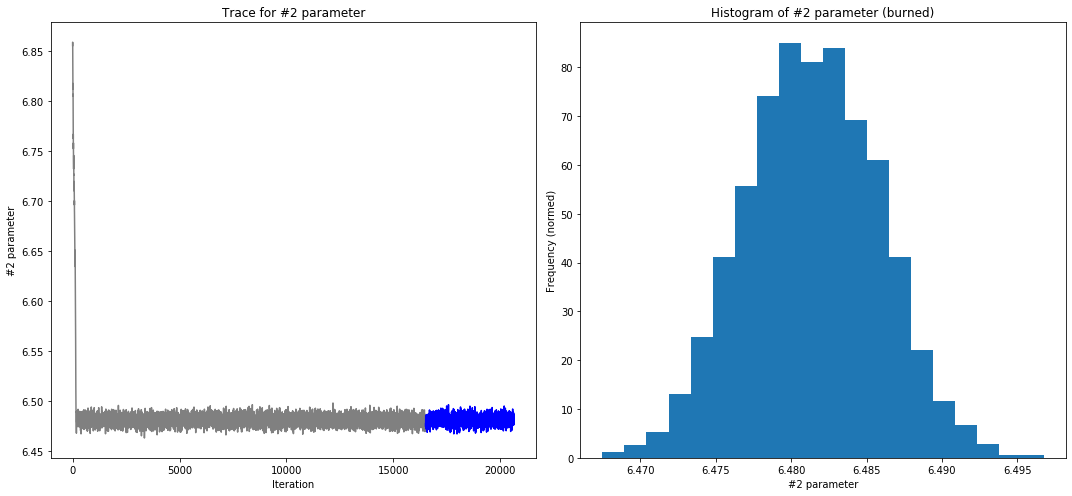

In [12]:
show_mcmc(accepted_v, rejected_v)
accepted_burned_v = burn_accepted(accepted_v, burn_in=0.8, show=True)

mean_v = np.mean(accepted_burned_v, axis=0)
cov_v = np.cov(accepted_burned_v.T)
print(mean_v)
print(cov_v)

To validate the model, we compute ???

## 2.5 Show fitting curves and QoI

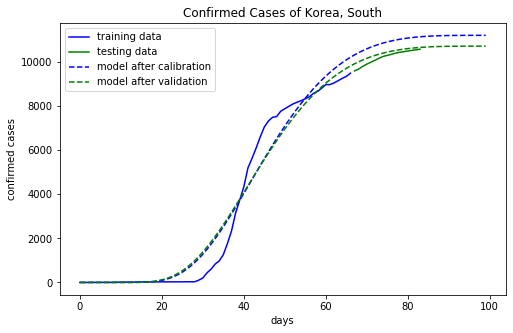

In [13]:
fig = plt.figure(figsize=(8,5))

# plot the curve
plt.plot(data_c[:,0],data_c[:,1], 'b-', label="training data")
plt.plot(data_v[:,0],data_v[:,1], 'g-', label="testing data")
plt.plot(np.arange(T), model(mean_c, np.arange(T), fix_params), 'b--', label="model after calibration")
plt.plot(np.arange(T), model(mean_v, np.arange(T), fix_params), 'g--', label="model after validation")

plt.xlabel("days")
plt.ylabel("confirmed cases")
plt.legend()
plt.title("Confirmed Cases of "+ country) 
plt.show()

10701.804490710954


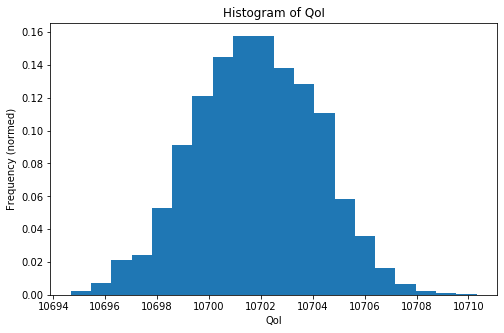

In [14]:
QoIs = [model(theta,[100],fix_params)[0] for theta in accepted_burned_v]

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.hist(QoIs, bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("QoI")
ax.set_title("Histogram of QoI")

QoI = sum(QoIs)/len(QoIs)
print(QoI)

# Compare Models with OPAL

# References

- **Viboud et al 2015** Viboud, C., Simonsen, L. and Chowell, G., 2016. A generalized-growth model to characterize the early ascending phase of infectious disease outbreaks. Epidemics, 15, pp.27-37.